# Lab_10 TCV3151 Computer Vision
Bagja 9102 Kurniawan <br> **1211501345**

In [2]:
!pip install opencv-contrib-python

## Question 1: Object recognition using local feature detection

(<matplotlib.image.AxesImage at 0x1a12d12bb50>, (-0.5, 1639.5, 460.5, -0.5))

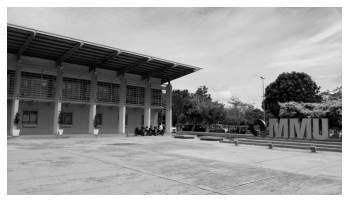

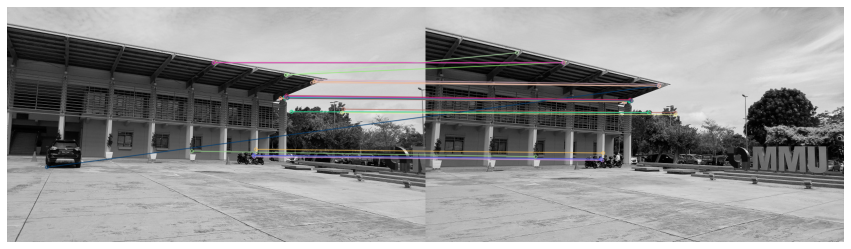

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

img_query = cv2.imread('query.jpg') # queryImage
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2GRAY) # convert color from BGR to gray
plt.imshow(img_query, cmap='gray'), plt.axis('off')

img_db = cv2.imread('database.jpg') # trainImage
img_db = cv2.cvtColor(img_db, cv2.COLOR_BGR2GRAY) # convert color from BGR to gray
plt.imshow(img_db, cmap='gray'), plt.axis('off')

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors 
kp1, des1 = orb.detectAndCompute(img_query, None)
kp2, des2 = orb.detectAndCompute(img_db, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn gives a list of lists as matches
img_ORB = cv2.drawMatchesKnn(img_query,kp1,img_db,kp2,good,None, flags=2)

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
ax.imshow(img_ORB), plt.axis('off')

### Another variation: AKAZE

(<matplotlib.image.AxesImage at 0x1a12d125be0>, (-0.5, 1639.5, 460.5, -0.5))

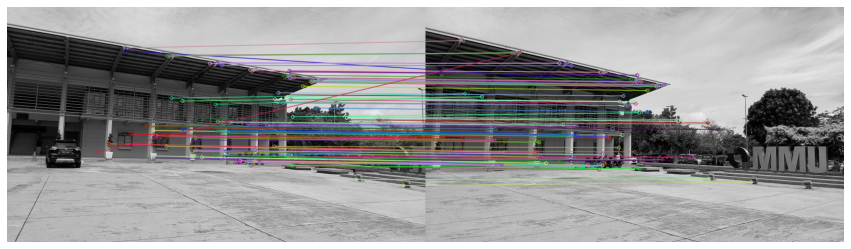

In [4]:
# Initiate AKAZE detector
akaze = cv2.AKAZE_create()
(kp1, des1) = akaze.detectAndCompute(img_query, None)
(kp2, des2) = akaze.detectAndCompute(img_db, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn gives a list of lists as matches
img_akaze = cv2.drawMatchesKnn(img_query,kp1,img_db,kp2,good, None, flags=2)

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
ax.imshow(img_akaze), plt.axis('off')

## Question 2: Application - Image Stitching

(<matplotlib.image.AxesImage at 0x1a12d114cd0>, (-0.5, 1639.5, 460.5, -0.5))

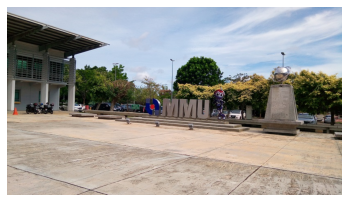

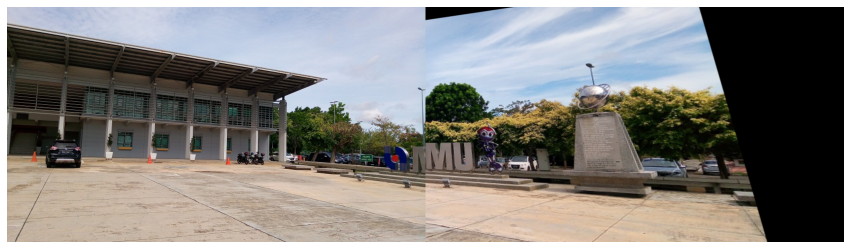

In [5]:
import numpy as np
import cv2
from skimage.transform import warp
from matplotlib import pyplot as plt
%matplotlib inline

f1 = cv2.imread('mmu_2.jpg')
f1 = cv2.cvtColor(f1, cv2.COLOR_BGR2RGB) # convert color from BGR to RGB
plt.imshow(f1, cmap='gray'), plt.axis('off')

f2 = cv2.imread('mmu_1.jpg')
f2 = cv2.cvtColor(f2, cv2.COLOR_BGR2RGB) # convert color from BGR to RGB
plt.imshow(f2, cmap='gray'), plt.axis('off')

akaze = cv2.AKAZE_create()
# find the keypoints and descriptors with SIFT
(kp1, des1) = akaze.detectAndCompute(f1, None)
(kp2, des2) = akaze.detectAndCompute(f2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
        matches = np.asarray(good)

if len(matches[:,0]) >= 4:
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    #print(H)
else:
    raise AssertionError('Can’t find enough keypoints.')

M1, N1 = f1.shape[:2]
M2, N2 = f2.shape[:2]

f_stitched = warp(f2, H, output_shape=(M1, N1+N2))

f1 = (f1 * 255).astype(np.uint8)

f_stitched[0:M1, 0:N1, :] = f1
f_stitched = (f_stitched * 255).astype(np.uint8)

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
ax.imshow(f_stitched), plt.axis('off')

## Question 3: Application - Image Registration

(<matplotlib.image.AxesImage at 0x1a13f8f9040>, (-0.5, 511.5, 373.5, -0.5))

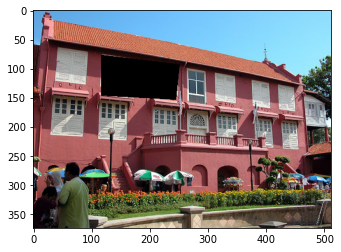

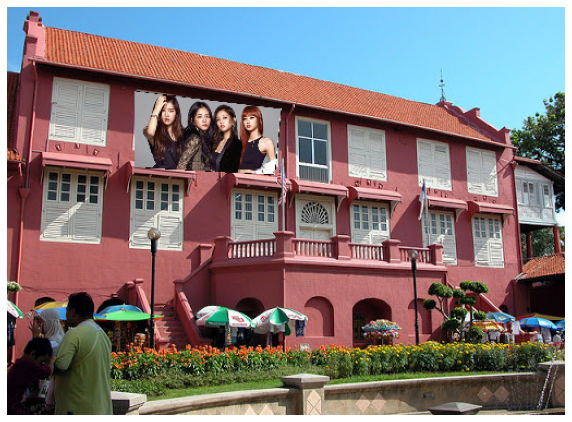

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

im_src = cv2.imread('src.jpg')
im_src = cv2.cvtColor(im_src, cv2.COLOR_BGR2RGB) # convert color from BGR to RGB
plt.imshow(im_src)

im_dst = cv2.imread('dest.jpg')
im_dst = cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB) # convert color from BGR to RGB
plt.imshow(im_dst)

[h, w, d] = im_src.shape # get the size of the image
pts_src = np.array([[0,0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=float)
pts_dst = np.array([[117, 77], [251, 93], [245, 153], [117, 146]], dtype=float)

# Find homography
M, mask = cv2.findHomography(pts_src, pts_dst)

# Use homography to warp image
[w, h, d] = im_dst.shape
temp = cv2.warpPerspective(im_src, M, (h, w))
plt.imshow(temp)

# Black out destination
cv2.fillConvexPoly(im_dst, pts_dst.astype(int), 0)
plt.imshow(im_dst)

# Add black out destination with homography
result = im_dst + temp
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(result), plt.axis('off')